<a href="https://colab.research.google.com/github/DiGyt/neuropynamics/blob/master/notebooks/Stability_analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Attention**: Please run this notebook in Google Colaboratory, else the interactive functionality might not work as intended


---



# Introduction

In this notebook you can interactively examine the stability of the underlying dynamical systems for different types neurons. We will show the equations for the underlying dynamical systems for the neuron models and implement them using the [brian2 toolbox](https://briansimulator.org) (Stimberg et al., 2019). Then, we will use our Python implementation of [pplane](https://www.mathworks.com/matlabcentral/fileexchange/61636-pplane) with [Sympy](https://www.sympy.org/en/index.html) to solve and examine the dynamical systems.

To take a look at the spiking and reset behavior of these neuron types and how we implemented them in brian2, please check out [this notebook](https://colab.research.google.com/github/DiGyt/neuropynamics/blob/master/notebooks/Single_neurons.ipynb) beforehand.

Before we dive in, we need to install some mandatory stuff by executing the cells below.

# Preparations

## Installation of required packages

In [2]:
# We use the brian2 toolbox for our models in the backend
!pip install brian2 -q

     |████████████████████████████████| 1.6MB 7.7MB/s 
     |████████████████████████████████| 5.8MB 46.1MB/s 



## Imports

In [11]:
# Main packages
import numpy as np
from sympy import symbols, solve, nsolve, lambdify, sympify, dsolve, Eq, solveset, linear_eq_to_matrix, nonlinsolve, Matrix, diff, sqrt, exp

# Brian2 package
# Unit definitions
from brian2 import mV, ms, volt, second, umetre, ufarad, siemens, cm, msiemens, amp, uA, nA
# Other stuff
from brian2 import start_scope, NeuronGroup, StateMonitor, run

# Plotting stuff
import matplotlib.pyplot as plt
import seaborn as sns

# Interactive widgets
import ipywidgets as widgets
from ipywidgets import interact, interactive, fixed, HBox, VBox, Layout

## Configuration

In [4]:
# Allow for larger output cells
from IPython.display import Javascript
display(Javascript('''google.colab.output.setIframeHeight(0, true, {maxHeight: 5000})'''))

# Set button layout
button_layout = Layout(width='180px', height='30px')

# Set slider config
slider_total_width = '800px'
slider_desc_width = '200px'

<IPython.core.display.Javascript object>

# 1D dynamical systems



## $I_{Na,p}$ model

To revise the stability of dynamical systems, we will take a look at the $I_{Na,p}$ model. 

The voltage change is determined by the following function:

$C * \dot{v} = I - g_L * (V-E_L) - g_Na*\frac{1}{1+e^{(V_{1/2}-V)/k}} * (V-E_{Na}) $ 

Notice that the function slightly differs from that in the lecture. This is actually a mistake in the slides. The correct equation can be seen in chapter 3.1.2 in Izhikevich (2007).

Aside from the voltage $v$, all other parameters are actually constants in this model. Therefore, this is a onedimensional dynamical system.  

Let's take a look at how we model this in Sympy. First, we have to define our constants. Then, the single variable in the expression has to be defined as a symbol so Python does not confuse this with an actual Python variable. Finally, we can define and display our expression.

In [39]:
# Define model parameters
C = 10/1000
v_onehalf = 1.5
k = 16
g_Na = 74
E_Na = 60
g_L = 19
E_L = -67
I = 0
# Define symbols
v = symbols('v')
# Define expression
expr = (I - g_Na * (1 / (1 + exp((v_onehalf - v) / k))) * (v - E_Na) - g_L * (v - E_L)) / C
# Show expression
display(expr)

-1900.0*v - 127300.0 - 7400.0*(v - 60)/(1 + 1.09828514030783*exp(-v/16))

As you can see, Sympy already changes the expression internally by resolving the constants and rearranging a lot of stuff.

If we now set this function to zero, we can find the attractors and equilibrim points of this system. To do just that, we can use Sympy. However, as this equation cannot easily be solved analytically with Sympy, we use `nsolve`, which is a numerical solver. As this one only finds one solution per run, we have to run it multiple times with different starting values to find multiple solutions. It is not guaranteed that we actually find all solutions.

In [76]:
# Function that tries to find multiple different solutions for the zero-crossings of an expression
def find_solutions(expr, target_variable):
  # Set up list of found solutions
  solutions = []
  # Iterate through different starting values and add new solutions
  for starting_point in [-1000,-100,-50,-10,-5,-1,0,1,5,10,50,100,1000]:
    # Use nsolve to try to find a solution with current starting point
    try:
      solution = nsolve(Eq(expr, target_variable), v, starting_point)
      # Check if solution is new
      if not solution in solutions:
        # Add to list of found solutions
        solutions.append(solution)  
    except:
      pass    
  # Return result
  return solutions

solutions = find_solutions(expr, v)
print(solutions)

[-52.4025572050729, -40.3594420345325, 30.8585337204716]


To examine where the attractions domains and equilibrium points are, let's plot the function. To do this, we first have to convert our expression to an actual function that takes input values using the `lambdify` method. Then we just plot it using Matplotlib. Additionally, we plot a point for each of the solutions above. 

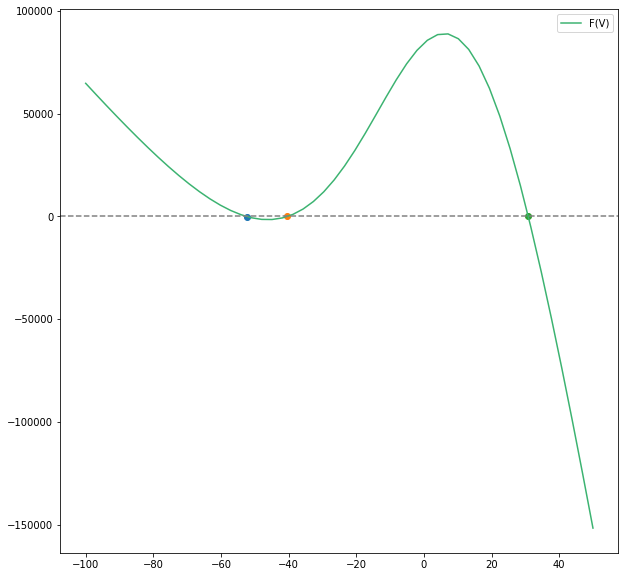

In [67]:
# Convert to function
function = lambdify((v), expr) 
# Generate range of x values
x_values = np.linspace(-100,50)
# Create plotting area
fig, ax = plt.subplots(figsize=(10,10))
# Calculate y values and plot the function
ax.plot(x_values, function(x_values), c = 'mediumseagreen', label = 'F(V)')
# Add horizontal line
ax.axhline(0, c = 'gray', ls = '--')
# Plot the equilibrium point(s)
for s in solutions:
  ax.scatter(s, function(float(s)))
# Add legend
ax.legend()
# Show plot
fig.show()

As you can see, the orange point separates the two attraction domains. Therefore this is an unstable equilibrium. Now lets see what happens if we apply an input current.

In [79]:
# Create function that plots the stuff above dynamically for a variable input current
def plot_nap_model(I):
  # Redefine expression
  expr = (I - g_Na * (1 / (1 + exp((v_onehalf - v) / k))) * (v - E_Na) - g_L * (v - E_L)) / C
  # Set equation to zero
  solutions = find_solutions(expr, v)
  # Convert to function
  function = lambdify((v), expr) 
  # Generate range of x values
  x_values = np.linspace(-100,50)
  # Create plotting area
  fig, ax = plt.subplots(figsize=(10,10))
  # Calculate y values and plot the function
  ax.plot(x_values, function(x_values), c = 'mediumseagreen', label = 'F(V)')
  # Add horizontal line
  ax.axhline(0, c = 'gray', ls = '--')
  # Plot the equilibrium point(s)
  for s in solutions:
    ax.scatter(s, function(float(s)))
  # Add legend
  ax.legend()
  # Show plot
  fig.show()

# Set default parameters 
I_def = 1.

# Create slider for input current
I_slider = widgets.FloatSlider(value = I_def, min = 0., max = 20., step = 0.01, description = 'Input current I:', readout_format = '.2f', continuous_update = False, layout = {'width': slider_total_width}, style = {'description_width': slider_desc_width})

# Make interactive widget for function above with the given sliders
main_widgets = interactive(plot_nap_model, I = I_slider)

# Display main widgets
display(main_widgets)


interactive(children=(FloatSlider(value=1.0, continuous_update=False, description='Input current I:', layout=L…

If you have not done it, try amping up the current to values of 15.4 or higher.

As you can see, the attraction domain on the lefthand side gets "smaller" with rising current until it finally disappears and the dynamical system is left with a single attraction domain. 

Our previously bistable model has now changed to a monostable solution. In terms of spiking behavior, our model now always enters an excited state, no matter the initial membrane potential.


# 2D dynamical systems

In the following, we will take a look at two neuron models that use a 2D dynamical system: The Izhikevich and FitzHugh-Nagumo model. 

Using the same sliders from the [notebook about single neurons](https://colab.research.google.com/github/DiGyt/neuropynamics/blob/master/notebooks/Single_neurons.ipynb), you may adjust the model parameters and examine their impact on the model nullclines, stable points and the trajectory when provided with an input current.

To determine the exact stable point type, we also analyze the eigenvalues similar to the lecture. To recall the types and the corresponding eigenvalues, check out the image below:

![Eigenvalue analysis](https://raw.githubusercontent.com/DiGyt/neuropynamics/master/src/utils/2d-stability.png)

## Main functions

Here we set up our main functions to examine a 2D dynamical system. The function `solve_dynamical_system` calculates the values for our quiver plot and then uses the previously defined functions `calculate_nullclines` and `examine_stable_points` to calculate the nullclines and determine the stable point type.

Finally, we create a single plot to show the results of the analysis as well as the simulated model trajectory when an external current is applied.

For more detail on these functions, check out our [Python implementation of pplane](https://colab.research.google.com/github/DiGyt/neuropynamics/blob/master/notebooks/pplane.ipynb).



In [55]:
def calculate_nullclines(eq, solvar, plotvar, inputrange):
  # Set our equations to zero and solve them
  eq = Eq(eq, 0)
  sol = solve(eq, solvar)
  nullclines = []
  # Calculate y-values for each of the solutions
  for s in sol:
      f = lambdify((plotvar), sol)
      nullclines.append([f(input) for input in inputrange])
  return nullclines

def examine_stable_points(expr1, expr2, x_var, y_var, solutions):
  # First, calculate the jacobian matrix for our equations
  equation_matrix = Matrix([expr1, expr2])
  var_mat = Matrix([x_var, y_var])
  jacobian = equation_matrix.jacobian(var_mat)
  # Set up list that contains all stable points
  stable_points = []
  # Calculate eigenvalues for each of the stablepoints
  for stable_point in solutions:
    # Eigenvalue calculation
    eqmat = jacobian.subs([(x_var, stable_point[0]), (y_var, stable_point[1])])
    eigenvalues = list(eqmat.eigenvals().keys())
    # Check the eigenvalues to determine type of stable point
    if eigenvalues[0].is_real:
        if eigenvalues[0] > 0 and eigenvalues[1] > 0:
            stable_point_type = 'Unstable Node'
        elif eigenvalues[0] < 0 and eigenvalues[1] < 0:
            stable_point_type = 'Stable Node'
        elif (eigenvalues[0] < 0 and eigenvalues[1] > 0) or (eigenvalues[0] > 0 and eigenvalues[1] < 0):
            stable_point_type = 'Saddle Point'
    else:
        if eigenvalues[0].args[0] > 0:
            stable_point_type = 'Unstable Focus'
        if eigenvalues[0].args[0] < 0:
            stable_point_type = 'Stable Focus'
    # Add tuple for each stable point to list
    stable_points.append((stable_point, stable_point_type))
  # Return list of stable points
  return stable_points

def solve_dynamical_system(expr1, expr2, x_range, y_range, x_var, y_var): 
  # Convert our equations to functions
  f1 = lambdify((x_var, y_var), expr1)
  f2 = lambdify((x_var, y_var), expr2)
  # Define range that we will examine the system in
  start_x = x_range[0]
  end_x = x_range[1]
  start_y = y_range[0]
  end_y = y_range[1]
  # Set up list of x and y values inside this range 
  x_range = np.linspace(start_x, end_x)
  y_range = np.linspace(start_y, end_y)
  total_range = np.linspace(min(start_x, start_y), max(end_x, end_y))
  # Compute quivers by calculating the expression for a combination of x and y values
  f1_val = [[f1(x_cur, y_cur) for x_cur in x_range] for y_cur in y_range];
  f2_val = [[f2(x_cur, y_cur) for x_cur in x_range] for y_cur in y_range];
  # Solve analytically using sympy
  solutions = solve((Eq(expr1, 0), Eq(expr2, 0)), x_var, y_var)  
  # Calculate nullclines
  x_nullclines = calculate_nullclines(expr1, y_var, x_var, total_range)
  y_nullclines = calculate_nullclines(expr2, y_var, x_var, total_range)
  # Get stable points and check their type
  stable_points = examine_stable_points(expr1, expr2, x_var, y_var, solutions)
  # Return relevant results
  return x_range, y_range, f1_val, f2_val, x_nullclines, y_nullclines, stable_points

def plot_dynamical_system(x_range, y_range, f1_val, f2_val, x_nullclines, y_nullclines, stable_points, x_behavior, y_behavior, x_var_name, y_var_name):
  # Create plotting area and set axis limits
  fig, ax = plt.subplots(figsize=(10,10))
  ax.set_xlim([x_range[0], x_range[-1]])
  ax.set_ylim([y_range[0], y_range[-1]])  
  # Set axis lables
  ax.set_xlabel(x_var_name)
  ax.set_ylabel(y_var_name)
  # Plot quivers
  ax.quiver(x_range, y_range, f1_val, f2_val, alpha=.5, headwidth = 3, headlength = 2, headaxislength = 2)
  # Plot nullclines
  [ax.plot(y_range, nullcline, c = 'b', alpha=.7, label= x_var_name + ' Nullcline') for nullcline in x_nullclines]
  [ax.plot(x_range, nullcline, c = 'r', alpha=.7, label= y_var_name + ' Nullcline') for nullcline in y_nullclines]
  # Plot stable points
  for stable_point in stable_points:
    # Extract information
    stable_point_x = stable_point[0][0]
    stable_point_y = stable_point[0][1]
    stable_point_type = stable_point[1]
    # Plot stable points with different color for each type 
    try: # We have to use try to ignore errors that occur when trying to plot complex value
      if stable_point_type == 'Unstable Node':
        ax.scatter(stable_point_x, stable_point_y, marker = '.', label = stable_point_type, s = 150, c = 'coral')
      elif stable_point_type == 'Stable Node':
        ax.scatter(stable_point_x, stable_point_y, marker = '.', label = stable_point_type, s = 150, c = 'cyan')
      elif stable_point_type == 'Saddle Point':
        ax.scatter(stable_point_x, stable_point_y, marker = '.', label = stable_point_type, s = 150, c = 'violet')
      elif stable_point_type == 'Unstable Focus':
        ax.scatter(stable_point_x, stable_point_y, marker = '.', label = stable_point_type, s = 150, c = 'orange')
      elif stable_point_type == 'Stable Focus':
        ax.scatter(stable_point_x, stable_point_y, marker = '.', label = stable_point_type, s = 150, c = 'springgreen')  
    except:
      # Do nothing for complex values
      pass
  # Plot the actual behavior of the variables over time
  ax.plot(x_behavior, y_behavior, c = 'mediumseagreen', label = 'Model trajectory')
  # Add legend
  ax.legend()
  # Show plot
  fig.show()

## Izhikevich model

The equations of the dynamical system of the Izhikevich model (Izhikevich, 2003) are as follows (remember that we deviate a bit from the equations given in the lecture as explained in the [notebook for single neurons](https://colab.research.google.com/github/DiGyt/neuropynamics/blob/master/notebooks/Single_neurons.ipynb):

$\dot{v} = I + 0.04v^2 + 5v + 140 - u$

$\dot{u} = a(bv - u)$

Notice that only the parameters $a$ and $b$ are actually contained in the second equation, whereas $c$ and $d$ only apply to the reset behavior of the neuron but do not affect the dynamical system.

In [58]:
# Brain 2 implementation of Izhikevich neuron
def create_izhikevich_neuron(v_max):
    """Creates a brian2 NeuronGroup that contains a single izhikevich neuron"""
    # Define differential equation for izhikevich neuron
    eqs = '''   
        dv/dt = I + (0.04/ms/mV)*v**2 + (5/ms)*v + 140*mV/ms - u : volt

        du/dt = a*(b*v-u) : volt/second
        
        I : volt/second 
        '''
    # Define reset function
    reset = ''' 
        v = c
        u = u + d
        '''
    # Define threshold
    threshold = 'v > {}*mV'.format(v_max)
    # Return NeuronGroup object
    return NeuronGroup(1, eqs, threshold = threshold, reset = reset, method = 'euler')

# Create function that creates a neuron and plots its behavior based on the given parameters
def plot_izhikevich_dynamical_sytem(I_ext, a_input, b_input, c_input, d_input, v_max):

  # Regular simulation of Izhikevich model using brian2
  # Start the scope to register all activity
  start_scope()
  # Define the neuron
  neuron = create_izhikevich_neuron(v_max)      
  # Set neuron parameters
  a = a_input/ms
  b = b_input/ms
  c = c_input * mV 
  d = d_input * volt/second  
  # Start monitoring the neurons state
  statemon = StateMonitor(source = neuron, variables = ['v', 'u'], record = 0)
  # Run neuron simulation for 100ms without input
  run(100*ms)
  # Set input current to neuron
  neuron.I = I_ext * volt / second
  # Run 500ms with input
  run(500*ms)
  # Remove input current to neuron
  neuron.I = 0 * volt / second
  # Run neuron simulation for 100ms without input
  run(100*ms)  
  
  # Define model for sympy and calculate nullclines  
  # Define the symbols
  v, u = symbols('v u')
  # First expression
  expr1 = I_ext + 0.04 * v**2 + 5*v + 140 - u
  # Second expression
  expr2 = a_input * (b_input * v - u)  

  # Solve dynamical system
  x_range, y_range, f1_val, f2_val, x_nullclines, y_nullclines, stable_points = solve_dynamical_system(expr1, expr2, x_range = [-120, 40], y_range = [-120, 40], x_var = v, y_var = u)

  # Plot results
  plot_dynamical_system(x_range, y_range, f1_val, f2_val, x_nullclines, y_nullclines, stable_points, x_behavior = statemon.v[0]/mV, y_behavior = statemon.u[0], x_var_name = 'v', y_var_name = 'w')
  
# Set default parameters 
I_ext_def = 0.3
a_def = 0.02
b_def = 0.2
c_def = -65.
d_def = 8.
vmax_def = 10.

# Create sliders for neuron parameters
a_slider = widgets.FloatSlider(value = a_def, min = 0., max = 0.15, step = 0.01, description = 'Recovery Time Constant a:', readout_format = '.2f', continuous_update = False, layout = {'width': slider_total_width}, style = {'description_width': slider_desc_width})
b_slider = widgets.FloatSlider(value = b_def, min = 0., max = 0.35, step = 0.01, description = 'Dynamic Behavior b:', readout_format = '.2f', continuous_update = False, layout = {'width': slider_total_width}, style = {'description_width': slider_desc_width}) # Somehow max = 0.3 does not work
c_slider = widgets.FloatSlider(value = c_def, min = -75., max = -40., step = 1, description = 'Voltage Reset Value c:', readout_format = '.1f', continuous_update = False, layout = {'width': slider_total_width}, style = {'description_width': slider_desc_width})
d_slider = widgets.FloatSlider(value = d_def, min = 0., max = 10., step = 1, description = 'Spike Activated Net Current d:', readout_format = '.1f', continuous_update = False, layout = {'width': slider_total_width}, style = {'description_width': slider_desc_width})

# Create slider for input current
I_slider = widgets.FloatSlider(value = I_ext_def, min = 0., max = 7., step = 0.01, description = 'Input Current I:', readout_format = '.2f', continuous_update = False, layout = {'width': slider_total_width}, style = {'description_width': slider_desc_width})

# Make interactive widget for function above with the given sliders
main_widgets = interactive(plot_izhikevich_dynamical_sytem, I_ext = I_slider, a_input = a_slider, b_input = b_slider, c_input = c_slider, d_input = d_slider, v_max = fixed(vmax_def))

# Create functions to set specific neuron configurations
def apply_config(I_ext, a, b, c, d):
  I_slider.value = I_ext
  a_slider.value = a
  b_slider.value = b
  c_slider.value = c
  d_slider.value = d

def reset_config(name):
  apply_config(I_ext = I_ext_def, a = a_def, b = b_def, c = c_def, d = d_def)

def apply_intrinsically_bursting_config(name):
  apply_config(I_ext = 12., a = a_def, b = b_def, c = -55, d = 4)

def apply_chattering_config(name):
  apply_config(I_ext = I_ext_def, a = a_def, b = b_def, c = -50, d = 2)

def apply_fast_spiking_config(name):
  apply_config(I_ext = I_ext_def, a = 0.1, b = b_def, c = c_def, d = d_def)

def apply_low_thresh_spiking_config(name):
  apply_config(I_ext = I_ext_def, a = a_def, b = 0.25, c = c_def, d = d_def)

def apply_resonator_config(name):
  apply_config(I_ext = I_ext_def, a = 0.1, b = 0.26, c = c_def, d = d_def)

# Create buttons for specific neuron configurations
# Reset button
regular_spiking_button = widgets.Button(description='Regular Spiking', layout = button_layout)
regular_spiking_button.on_click(reset_config)
# Intrinsically bursting
intrinsically_bursting_button = widgets.Button(description='Intrinsically Bursting', layout = button_layout)
intrinsically_bursting_button.on_click(apply_intrinsically_bursting_config)
# Chattering neuron
chattering_button = widgets.Button(description='Chattering', layout = button_layout)
chattering_button.on_click(apply_chattering_config)
# Fast spiking
fast_spiking_button = widgets.Button(description='Fast Spiking', layout = button_layout)
fast_spiking_button.on_click(apply_fast_spiking_config)
# Low-threshold spiking
low_thresh_spiking_button = widgets.Button(description='Low-threshold Spiking', layout = button_layout)
low_thresh_spiking_button.on_click(apply_low_thresh_spiking_config)
# Resonator
resonator_button = widgets.Button(description='Resonator', layout = button_layout)
resonator_button.on_click(apply_resonator_config)

# Place buttons into grid
button_description = widgets.Label(value='Select predefined neuron types:', layout = Layout(width='300px', height='30px'))
buttons = HBox(children=[regular_spiking_button, intrinsically_bursting_button, chattering_button, fast_spiking_button, low_thresh_spiking_button, resonator_button])

# Display main widget and buttons
parameter_description = widgets.Label(value='Set parameters yourself:', layout = Layout(width='300px', height='30px'))
display(VBox(children=[VBox(children=[button_description, buttons]), VBox(children=[parameter_description, main_widgets])]))

As you can see, only the aptly named parameter $b$ (and the input current) actually influences the dynamical system. Even though $a$ appears in the equations, it does not influence the dynamical system as it is only a constant used for multiplication and therefore is irrelevant to the solutions of the dynamical system.

## FitzHugh-Nagumo model

For the FitzHugh-Nagumo model (FitzHugh, 1961; Nagumo et al., 1962), we deviate a bit from the equations for the dynamical system given in the lecture and instead use the original ones:

$\dot{v} = v - \frac{v^3}{3} - w + I$

$\dot{w} = \frac{v + a - bw}{\tau}$


In [51]:
# Brain2 implementation of the neuron model
def create_fhn_neuron():
    """Creates a brian2 NeuronGroup that contains a single FitzHugh Nagumo neuron"""    
    # Define differential equation for FitzHugh-Nagumo neuron model
    eqs = '''
        dv/dt = 1/ms * (v - (v**3 / 3) / (mV**2) - w + I * Mohm) : volt

        dw/dt = (v + a - b*w) / tau : volt

        I : amp
        '''   
    # Return NeuronGroup object without threshold
    return NeuronGroup(1, eqs, method='euler')

# Function for plotting the dynamical system
def plot_fhn_dynamical_sytem(I_ext, a_input, b_input, tau_input):

  # Regular simulation of FitzHugh-Nagumo model using brian2
  # Start the scope for the brian2 toolbox to register all neurons that are created
  start_scope()
  # Define the neuron
  neuron = create_fhn_neuron()      
  # Set neuron parameters
  a = a_input*mV
  b = b_input
  tau = tau_input*ms
  # Start monitoring the neurons state
  statemon = StateMonitor(source = neuron, variables = ['v', 'w', 'I'], record = 0)
  # Run neuron simulation for 100ms without input
  run(100*ms)
  # Set input current to neuron
  neuron.I = I_ext * nA
  # Run 500ms with input
  run(500*ms)
  # Remove input current to neuron
  neuron.I = 0 * nA
  # Run neuron simulation for 100ms without input
  run(100*ms)

  # Define model for sympy and calculate nullclines  
  # Define the symbols
  v, w = symbols('v w')
  # First expression
  expr1 = v - v**3 / 3 - w + I_ext  
  # Second expression
  expr2 = (v + a_input - b_input * w) / tau_input  

  # Solve dynamical system
  x_range, y_range, f1_val, f2_val, x_nullclines, y_nullclines, stable_points = solve_dynamical_system(expr1, expr2, x_range = [-2.1, 2.1], y_range = [-2.1, 2.1], x_var = v, y_var = w)

  # Plot results
  plot_dynamical_system(x_range, y_range, f1_val, f2_val, x_nullclines, y_nullclines, stable_points, x_behavior = statemon.v[0]/mV, y_behavior = statemon.w[0]/mV, x_var_name = 'v', y_var_name = 'w')

# Set default parameters 
I_ext_def = 0.5
a_def = 0.7
b_def = 0.8
tau_def = 12.5

# Create sliders for neuron parameters
a_slider = widgets.FloatSlider(value = a_def, min = 0., max = 1., step = 0.01, description = 'a:', readout_format = '.2f', continuous_update = False, layout = {'width': slider_total_width}, style = {'description_width': slider_desc_width}) 
b_slider = widgets.FloatSlider(value = b_def, min = 0.5, max = 1.5, step = 0.01, description = 'b:', readout_format = '.2f', continuous_update = False, layout = {'width': slider_total_width}, style = {'description_width': slider_desc_width}) 
tau_slider = widgets.FloatSlider(value = tau_def, min = 0., max = 20, step = 0.01, description = 'tau:', readout_format = '.2f', continuous_update = False, layout = {'width': slider_total_width}, style = {'description_width': slider_desc_width}) 

# Create slider for input current
I_ext_slider = widgets.FloatSlider(value = I_ext_def, min = 0., max = 1., step = 0.01, description = 'I:', readout_format = '.2f', continuous_update = False, layout = {'width': slider_total_width}, style = {'description_width': slider_desc_width})

# Make interactive widget for function above with the given sliders
main_widgets = interactive(plot_fhn_dynamical_sytem, I_ext = I_ext_slider, a_input = a_slider, b_input = b_slider, tau_input = tau_slider)

def reset_fhn(name):
  I_ext_slider.value = I_ext_def  
  a_slider.value = a_def
  b_slider.value = b_def
  tau_slider.value = tau_def

# Reset button
reset_button = widgets.Button(description='Reset', layout = button_layout)
reset_button.on_click(reset_fhn)

# Display main widgets and reset button
display(VBox(children=[reset_button, main_widgets]))

In the [notebook for single neuron behavior] we already explained that the FitzHugh-Nagumo model is an example of a [relaxation oscillator](https://en.wikipedia.org/wiki/Relaxation_oscillator). As you can see in the plot above, the model jumps around the cubic nullcline of the membrane potential $v$ and therefore produces an oscillating effect. 

# Final notes

We hope you enjoyed this examination of the stability of dynamical systems for some neuron models. 

Please take a look at the other notebooks in our [repository](https://github.com/DiGyt/neuropynamics) to learn more about dendritic computation, bifurcation, multi-neuron networks and phase plots of dynamical systems.

# References

FitzHugh, R. (1961). Impulses and physiological states in theoretical models of nerve membrane. *Biophysical journal*, *1*(6), 445.

Izhikevich, E. M. (2003). Simple model of spiking neurons. *IEEE Transactions on neural networks*, *14*(6), 1569-1572.

Izhikevich, E. M. (2007). *Dynamical systems in neuroscience*. MIT press.

Nagumo, J., Arimoto, S., & Yoshizawa, S. (1962). An active pulse transmission line simulating nerve axon. *Proceedings of the IRE*, *50*(10), 2061-2070.

Stimberg, M., Brette, R., & Goodman, D. F. (2019). Brian 2, an intuitive and efficient neural simulator. *Elife*, 8, e47314.